<h1>Strategies to prevent overfitting in neural networks</h1>

<h3>(DS4A Colombia 2020_02 - Extended Case 07- Alexander Ortega - Team 16)</h3>

In [1]:
%matplotlib inline

# Librerias incluidas de manera personal
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Librerias incluidas por defecto en el extended case
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.</p>
<p><strong>Business Problem.</strong> Your task is to <strong>build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)</strong>.</p>
<p><strong>Analytical Context.</strong> We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the <em>exact</em> star rating. The lowest score is 1 and the highest is 5.</p>
<p>Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.</p>

<h2>Setting up and preparing the data</h2>
<p>We'll mainly be using the <code>keras</code> module from TensorFlow, but we'll also use <code>pandas</code> to read the CSV file and <code>sklearn</code> for some helper functions. We'll be using only the "Text" and "Score" columns in the <code>Reviews.csv</code> file:</p>

In [2]:
%%time 
# Emplearemos la función time para tener un estimado del tiempo que toma la tarea

# Cargamos el dataset compartido con el material del extended case
# (dejamos la opción de nrows como se encuentra por defecto)
# (asi se importaran unicamante las primeras 262084 filas )
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

Wall time: 2.75 s


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Visualicemos las caracteristicas generales del dataframe
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262084 entries, 0 to 262083
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      262084 non-null  int64 
 1   ProductId               262084 non-null  object
 2   UserId                  262084 non-null  object
 3   ProfileName             262076 non-null  object
 4   HelpfulnessNumerator    262084 non-null  int64 
 5   HelpfulnessDenominator  262084 non-null  int64 
 6   Score                   262084 non-null  int64 
 7   Time                    262084 non-null  int64 
 8   Summary                 262074 non-null  object
 9   Text                    262084 non-null  object
dtypes: int64(5), object(5)
memory usage: 20.0+ MB


In [4]:
# Visualicemos los posibles valores de la variable de interés (Score)
amazon_reviews.Score.unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [5]:
# Visualicemos la distribución de valores de la variable de interés (Score)
amazon_reviews.Score.value_counts()

5    165617
4     37889
1     24109
3     20434
2     14035
Name: Score, dtype: int64

In [6]:
# Generamos un dataframe con las variables de interes que describe el problema
df=amazon_reviews[["Text", "Score"]]
df

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
262079,Bought Lucy's cookies after I heard about them...,1
262080,I am not sure what I expected but I found the ...,3
262081,SO disappointed off taste all the flavors tast...,1
262082,"If you have to eat gluten free, these cookies ...",2


<h3>Exercise 1:</h3>
<p>Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in <code>amazon_reviews</code> into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.</p>
<p><strong>Hint:</strong> <code>keras</code> will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.</p>

**Answer.**

In [7]:
# Recordemos inicialmente el dataframe del que partimos
df

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
262079,Bought Lucy's cookies after I heard about them...,1
262080,I am not sure what I expected but I found the ...,3
262081,SO disappointed off taste all the flavors tast...,1
262082,"If you have to eat gluten free, these cookies ...",2


In [8]:
# Obtengamos una lista ordenada con todos los posibles valores que puede tomar Score
review_values=list(amazon_reviews.Score.unique())
review_values.sort()
review_values

[1, 2, 3, 4, 5]

In [9]:
# Generamos un dataset vacío en el cual almacenaremos los resultados del ciclo
df_first_1000_each_value=pd.DataFrame(columns = ['Text','Score'])

# Generamos un ciclo que nos permita almacenar los primeros 1000 resultados de cada Score
# en el dataframe ya definido
for value in review_values:
    first_1000 = df[df.Score==value].head(1000)
    df_first_1000_each_value=df_first_1000_each_value.append(first_1000)

# Imprimimos el dataset obtenido para corroborar su longitud y composición
df_first_1000_each_value

,Text,Score
1,Product arrived labeled as Jumbo Salted Peanut...,1
12,My cats have been happily eating Felidae Plati...,1
26,"The candy is just red , No flavor . Just plan...",1
50,"This oatmeal is not good. Its mushy, soft, I d...",1
62,Arrived in 6 days and were so stale i could no...,1
...,...,...
1528,i followed the easy instructions and these tur...,5
1529,WE LOVE LOVE LOVE these muffins. They are mois...,5
1532,I brought 2 bottles. One I carry in my pocket...,5
1541,I really like this soup. It is mild and I don...,5


In [10]:
# Aplicamos el hint:
# (dado que keras espera valores que vayan de 0 a 4, y no de 1 a 5, restamos 1 al Score)
df_first_1000_each_value.Score=df_first_1000_each_value.Score.apply(lambda x: x-1)
df_first_1000_each_value

,Text,Score
1,Product arrived labeled as Jumbo Salted Peanut...,0
12,My cats have been happily eating Felidae Plati...,0
26,"The candy is just red , No flavor . Just plan...",0
50,"This oatmeal is not good. Its mushy, soft, I d...",0
62,Arrived in 6 days and were so stale i could no...,0
...,...,...
1528,i followed the easy instructions and these tur...,4
1529,WE LOVE LOVE LOVE these muffins. They are mois...,4
1532,I brought 2 bottles. One I carry in my pocket...,4
1541,I really like this soup. It is mild and I don...,4


In [11]:
# Empleando sklearn generamos un train_test_split de los dados en una relacion 80/20

# Definimos nuestra variable predictora y nuestro target
X = df_first_1000_each_value.Text
y = df_first_1000_each_value.Score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Imprimamos cada una de los conjuntos de entrenamiento y de test para corroborar 
# que presentan las dimensiones y el contenido adecuado
for x in  [X_train, X_test, y_train, y_test]:
    print ('---------------------------------------------')
    print (x)
    print ('---------------------------------------------')
    print()

---------------------------------------------
338     I like a lot of sesame oil and use it in salad...
1047    This coffee company delivers on great coffee t...
8656    The coffee tasted bitter and like it was burnt...
4665    This crispbread is nice and thin - great for t...
291     If you want an organic energy shot, your choic...
                              ...                        
655     First time I've ever used Agave Nectar -- and ...
4980    I purchase Banh Trang Spring Rolls Skin freque...
678     I love these chips. The flavor is not plain. T...
5457    I am a strong believer in giving my baby organ...
9365    The coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object
---------------------------------------------

---------------------------------------------
8602     I love Wolfgang Puck products but the coffee i...
6894     Here's yet another carbonated juice drink, com...
7664     My golden retriever loves these bones!  I orde...
1147  

-------

<h2>Tokenizing our texts</h2>
<p>Keras comes with its own functions to preprocess text, including a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a> (a mapping from each word in our corpus to a unique integer). Unlike the <code>CountVectorizer</code> from <code>sklearn</code>, which produces sparse matrices, <code>keras</code> often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:</p>
<ol>
<li>Create a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a>.</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences">Create sequences</a> from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences">Pad or truncate</a> each sequence to a fixed length (very short texts get <code>0</code>s added to them, while very long ones are truncated).</li>
</ol>
<p>The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.</p>

<h3>Exercise 2:</h3>
<p>In this exercise, you will learn how to use the <code>tf.keras.preprocessing.text.Tokenizer</code> tool to carry out the preprocessing steps described above.</p>
<h4>2.1</h4>
<p>Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?</p>

**Answer.**

In [13]:
# Recordemos la variable que almacena el texto del conjunto de entrenamiento
X_train

338     I like a lot of sesame oil and use it in salad...
1047    This coffee company delivers on great coffee t...
8656    The coffee tasted bitter and like it was burnt...
4665    This crispbread is nice and thin - great for t...
291     If you want an organic energy shot, your choic...
                              ...                        
655     First time I've ever used Agave Nectar -- and ...
4980    I purchase Banh Trang Spring Rolls Skin freque...
678     I love these chips. The flavor is not plain. T...
5457    I am a strong believer in giving my baby organ...
9365    The coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object

In [14]:
# Removemos los caracteres especiales de cada registro (solo nos interesan las palabras)
pattern = r"[^\w]" 
X_train_no_sp = X_train.apply(lambda x : re.sub(pattern, " ", x))
X_train_no_sp

338     I like a lot of sesame oil and use it in salad...
1047    This coffee company delivers on great coffee t...
8656    The coffee tasted bitter and like it was burnt...
4665    This crispbread is nice and thin   great for t...
291     If you want an organic energy shot  your choic...
                              ...                        
655     First time I ve ever used Agave Nectar    and ...
4980    I purchase Banh Trang Spring Rolls Skin freque...
678     I love these chips  The flavor is not plain  T...
5457    I am a strong believer in giving my baby organ...
9365    The coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object

In [15]:
# Llevamos a minusculas todas las palabras
X_train_no_sp_lower = X_train_no_sp.apply(lambda x : x.lower())
X_train_no_sp_lower

338     i like a lot of sesame oil and use it in salad...
1047    this coffee company delivers on great coffee t...
8656    the coffee tasted bitter and like it was burnt...
4665    this crispbread is nice and thin   great for t...
291     if you want an organic energy shot  your choic...
                              ...                        
655     first time i ve ever used agave nectar    and ...
4980    i purchase banh trang spring rolls skin freque...
678     i love these chips  the flavor is not plain  t...
5457    i am a strong believer in giving my baby organ...
9365    the coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object

In [16]:
# Unimos todos los textos en uno único
X_train_join=' '.join(X_train_no_sp_lower)

# Visualizamos los primeros 2000 registros para corroborar la salida
X_train_join[0:2000]

'i like a lot of sesame oil and use it in salads regularly   great quality  flavor and aroma   can t beat that its organic  this coffee company delivers on great coffee taste    i like my coffee with deep  robust taste and jeremiah s always is    it makes me glad to purchase it    thanks   the coffee tasted bitter and like it was burnt   i cleaned the machine and it still tasted bitter and burnt   will not order this again  this crispbread is nice and thin   great for those with more sensitive teeth  br    br   i eat 3 of these in the morning for breakfast with smuckers sugar free jelly on them  br   guilt free and delicious  br    br   you do have to be a little careful when spreading heavy stuff on them like peanut butter  br   if you press too hard they can break  br    br   one thing you can t tell from the box is that there are actually 2 air tight packs in the box  br    br   i m currently eating these and the ryvita sesame rye crispbread  br   highly recommend both  br    br   n

In [17]:
# Separamos en palabras individuales
X_train_split = X_train_join.split()

# Visualizamos los primeros 20 registros para corroborar la salida
X_train_split[0:20]

['i',
 'like',
 'a',
 'lot',
 'of',
 'sesame',
 'oil',
 'and',
 'use',
 'it',
 'in',
 'salads',
 'regularly',
 'great',
 'quality',
 'flavor',
 'and',
 'aroma',
 'can',
 't']

In [18]:
# Hacemos la transformación de lista a set para que no tome valores repetidos
# (los set acorde a las propiedades de conjuntos presentan elementos que son únicos)
X_train_unique_words = set(X_train_split)
# print(X_train_set)

In [19]:
# Calculamos la cantidad de palabras únicas en el set de entrenamiento
len(X_train_unique_words)

12888

In [20]:
# Combinando todas las funciones descritas, generemos ahora una 
# función única que haga el conteo de palabras por registro
def words_per_row(X):
    pattern = r"[^\w]"
    X_words =  X.apply(lambda x : len(re.sub(pattern, " ", x).lower().split()))
    return X_words

In [21]:
# Apliquemos el contador de palabras definido a nuestro data de entrenamiento
# y generemos un dataframe a partir de la matriz obtenida
X_train_counted = words_per_row(X_train).to_frame().rename(columns={"Text": "cant_words"})
X_train_counted

,cant_words
338,24
1047,29
8656,25
4665,157
291,107
...,...
655,20
4980,124
678,37
5457,129


<Figure size 2160x576 with 0 Axes>

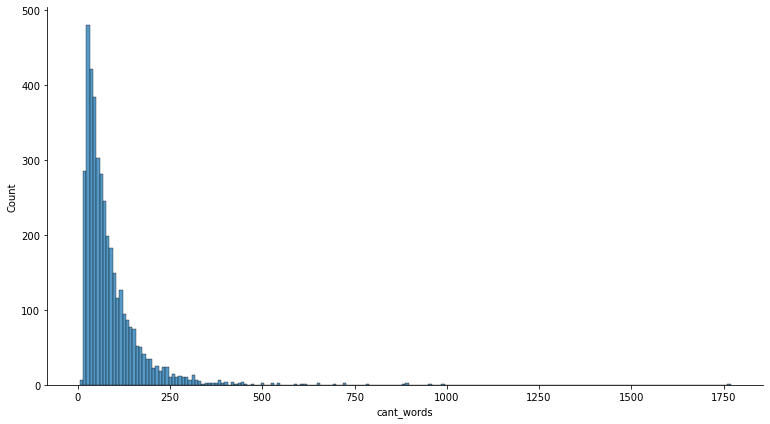

In [22]:
# Visualicemos la distribución de la cantidad de palabras para cada registo
# en el conjunto de entrenamiento
plt.figure(figsize=(30,8))
sns.displot(x='cant_words', data=X_train_counted, height=6, aspect=1.8)

In [23]:
# Calculemos los estadisticos más representativos de la distribución
X_train_counted.describe()

,cant_words
count,4000.000000
mean,87.216500
std,84.960763
min,6.000000
25%,37.000000
50%,63.000000
75%,108.000000
max,1769.000000


In [24]:
# Calculemos de manera especifica el percentil requerido (percentil 80)
X_train_counted.quantile(.8)

cant_words    123.0
Name: 0.8, dtype: float64

We finally found that 80% of the records that are part of the training set have an extension of 123 words or less (80th percentile).

-------

<h4>2.2</h4>
<p>Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): </p>

In [25]:
# Recordemos nuestra matriz de datos de entrenamiento
X_train

338     I like a lot of sesame oil and use it in salad...
1047    This coffee company delivers on great coffee t...
8656    The coffee tasted bitter and like it was burnt...
4665    This crispbread is nice and thin - great for t...
291     If you want an organic energy shot, your choic...
                              ...                        
655     First time I've ever used Agave Nectar -- and ...
4980    I purchase Banh Trang Spring Rolls Skin freque...
678     I love these chips. The flavor is not plain. T...
5457    I am a strong believer in giving my baby organ...
9365    The coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object

In [26]:
# Instanciamos un tokenizador de keras con 20000 palabras
# (linea incluida por defecto en el extended case)
# We create the tokenizer using only top 20000 words
tokenizer = Tokenizer(num_words=20000) 

In [27]:
# Entrenamos el tokenizador con el conjunto de entrenamiento
# (linea incluida por defecto en el extended case)
# Then, we create the text->indices mapping.
tokenizer.fit_on_texts(X_train)   

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

**Answer.**

In [28]:
# Imprimimos tal como se sugiere tokenizer.word_index
# (la impresión esta ocuta debida su extensión, si se desa visualizar, solo descomentar)
# print(tokenizer.word_index) 
tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'is': 8,
 'br': 9,
 'this': 10,
 'in': 11,
 'for': 12,
 'that': 13,
 'not': 14,
 'but': 15,
 'my': 16,
 'with': 17,
 'was': 18,
 'have': 19,
 'you': 20,
 'are': 21,
 'they': 22,
 'as': 23,
 'like': 24,
 'on': 25,
 'so': 26,
 'these': 27,
 'be': 28,
 'taste': 29,
 'good': 30,
 'if': 31,
 'them': 32,
 'product': 33,
 'or': 34,
 'coffee': 35,
 'just': 36,
 'all': 37,
 'at': 38,
 'very': 39,
 'one': 40,
 'flavor': 41,
 'would': 42,
 "it's": 43,
 'had': 44,
 'can': 45,
 'from': 46,
 'more': 47,
 'when': 48,
 'me': 49,
 'than': 50,
 'no': 51,
 'will': 52,
 'out': 53,
 'has': 54,
 'we': 55,
 'other': 56,
 'great': 57,
 'were': 58,
 'much': 59,
 'some': 60,
 'really': 61,
 "don't": 62,
 'there': 63,
 'up': 64,
 'too': 65,
 'only': 66,
 'chips': 67,
 'because': 68,
 'about': 69,
 'get': 70,
 'an': 71,
 'amazon': 72,
 'food': 73,
 'what': 74,
 'buy': 75,
 'your': 76,
 'sugar': 77,
 'better': 78,
 'which': 79,
 'little': 80,
 

We can see that **tokenizer.word_index** gives us a dictionary, from which I intuit, a descending ranking of the words that appear most frequently in our training set are found.

In [29]:
# Nos familiarizamos con la fución tokenizer.texts_to_sequences
tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 36, 357, 39, 39, 30]]

We can see that **tokenizer.texts_to_sequences** gives us a list that contains the hierarchy indices (according to the tokenizer.word_index dictionary) for each of the words contained in an input list.

In [30]:
# Nos familiarizamos con la fución tokenizer.sequences_to_texts
print(tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]]))

['did have world your 3 destroying figure ummmm']


In a complementary way **tokenizer.sequences_to_texts** gives us a list that contains the words (according to the tokenizer.word_index dictionary) for each of the indices contained in an input list.

-------

<h4>2.3</h4>
<p>Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the <code>pad_sequences</code> function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as <code>train_sequences</code> and <code>test_sequences</code>.</p>

**Answer.**

In [31]:
# Recordemos la variable que almacena el texto del conjunto de entrenamiento
X_train

338     I like a lot of sesame oil and use it in salad...
1047    This coffee company delivers on great coffee t...
8656    The coffee tasted bitter and like it was burnt...
4665    This crispbread is nice and thin - great for t...
291     If you want an organic energy shot, your choic...
                              ...                        
655     First time I've ever used Agave Nectar -- and ...
4980    I purchase Banh Trang Spring Rolls Skin freque...
678     I love these chips. The flavor is not plain. T...
5457    I am a strong believer in giving my baby organ...
9365    The coffee tasted bitter and like it was burnt...
Name: Text, Length: 4000, dtype: object

In [32]:
# Encontremos los indices jerarquicos de las palabras contenidas 
# en cada uno de los registros de nuestro conjunto de entrenamiento
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Imprimamos el primer registro para corroborar que funciona correctamante
X_train_seq[0:1]

[[2,
  24,
  3,
  188,
  7,
  3261,
  321,
  4,
  85,
  6,
  11,
  2375,
  1455,
  57,
  194,
  41,
  4,
  587,
  181,
  1279,
  13,
  195,
  165]]

The **pad_sequences** function allows us to make lists with the same number of elements from the maxlen argument. If it presents fewer records, it fills them with zeros, and if it presents more records, it truncates them starting from the back to the front.

In [33]:
# Empleemos la función pad_sequences que nos permite llevar cada 
# registro a la misma longitud de indices
# (empleando como entrada los datos de entrenamiento X_train)
X_train_seq_eq_len = pad_sequences(X_train_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
X_train_seq_eq_len[0:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    2,   24,    3,  188,    7, 3261,
         321,    4,   85,    6,   11, 2375, 1455,   57,  194,   41,    4,
         587,  181, 1279,   13,  195,  165],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

In [34]:
# Empleemos la función pad_sequences que nos permite llevar cada 
# registro a la misma longitud de indices
# (empleando como entrada los datos de entrenamiento X_train)
train_sequences = pad_sequences(X_train_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
train_sequences[0:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    2,   24,    3,  188,    7, 3261,
         321,    4,   85,    6,   11, 2375, 1455,   57,  194,   41,    4,
         587,  181, 1279,   13,  195,  165],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

In [35]:
# Realizaremos el mismo procedimiento ya descrito para X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
test_sequences = pad_sequences(X_test_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
test_sequences[0:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     2,    86,   494,   558,   190,    15,     1,    35,
            8,    39,   734,     9,    63,     8,     3,   411,    41,
          259,   137,  3760,     9,    60, 11242,   544,    19,   714,
           53,    37,     1,   231,   558,   190,     9, 11243],
       [  339,   323,   166,     7,   490,     3,    10,    40,   150,
            

-------

<h2>Building a basic neural network model</h2>
<p>Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs <a href="https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/">one-hot encoding</a> on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.</p>
<p>Before we train a <code>keras</code> model, there is an additional <code>compile</code> step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the <code>fit</code> function. All of this is shown below.</p>
<p>Note the <code>validation_split=0.2</code> argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:</p>

In [36]:
# Modelo de Neural Networks con las especificaciones arriba descritas
# (modelo incluido por defecto en el extended case)

# Paso 01. Se instancia el modelo empleando Sequential de keras
# (viene de from tensorflow.keras.models import Sequential)
model = Sequential()

# Paso 02. Se genera una capa para el embedding (one hot encoding)
model.add(Embedding(20000, 128, input_length=116))

# Paso 03. Se generan 2 capas con 128 neuronas cada una
# - Dense: hace referencia a que todas las neuronas estaran conectadas en dicha capa.
# - Cantidad de neuronas: 128 cada una
# - Función de activación: relu (bajo cero es cero, y despues y = x)
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

# Paso 03. XXX
model.add(GlobalMaxPooling1D())

# Paso 04. Se genera 1 capa de salida con 5 neuronas
# - Dense: hace referencia a que todas las neuronas estaran conectadas en dicha capa.
# - Cantidad de neuronas: 128 cada una
# - Función de activación: sigmoid (tal como en la regresión logística, estima 0 o 1 a partir de probabilidad)
model.add(Dense(5, activation='sigmoid'))

# Paso 05. Se compila el modelo generado enpleando 
# - loss: hace referencia a la función de perdida.
# - optimizer: adam por defecto
# - metrics: accuracy en este caso, pero puede elegirse la métrics propia de interes.
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# Imprimimos el resumen de las capas del modelo compilado
# (linea incluida por defecto en el extended case)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Recordemos nuestro train_sequences
train_sequences

array([[  0,   0,   0, ...,  13, 195, 165],
       [  0,   0,   0, ..., 237,   6, 738],
       [  0,   0,   0, ..., 134,  10,  98],
       ...,
       [  0,   0,   0, ...,   3,  57,  41],
       [289,  23,  59, ...,  11, 209, 684],
       [  0,   0,   0, ..., 134,  10,  98]])

In [39]:
# Recordemos nuestro y_train
y_train

338     4
1047    4
8656    0
4665    3
291     4
       ..
655     4
4980    0
678     3
5457    3
9365    0
Name: Score, Length: 4000, dtype: int64

In [40]:
# A partir del modelo compilado, generamos su entrenamiento a partir 
# de los train_sequences y se sus targets asociados (ambos asociados a datos de entrenamiento)
# (linea incluida por defecto en el extended case)
# - validation_split: entrenarnará y vvalidara con una relación de datos de este porcentaje.
# - epochs: cantidad de iteraciones que hara para hacer el ajuste de los w de la red
model.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5810 - accuracy: 0.2722 - val_loss: 1.4991 - val_accuracy: 0.3675
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.3562 - accuracy: 0.4403 - val_loss: 1.3070 - val_accuracy: 0.4225
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.0365 - accuracy: 0.5934 - val_loss: 1.2652 - val_accuracy: 0.4500
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.6986 - accuracy: 0.7584 - val_loss: 1.3379 - val_accuracy: 0.4600
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.3983 - accuracy: 0.8903 - val_loss: 1.5282 - val_accuracy: 0.4538
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.1967 - accuracy: 0.9588 - val_loss: 1.7337 - val_accuracy: 0.4450
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

<h3>Exercise 3:</h3>
<p>How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?</p>

**Answer.**

In order to generate a comparison of the performance of the model we need to establish a reference model. In this case, as we want to classify our outputs in 5 groups, a simple model would consist of labeling all the samples with a single qualification. Since we have generated the samples with a homogeneous distribution with respect to their target, the maximum accuracy that could be achieved under such a model would be 20%.

We note that the accuracy value for the validation data obtained after 10 epochs is 42.88%, which is much higher than that of the base model. However, if we compare the accuracy for the train and validation data, we can observe that these are radically different (acurracy in the training set is more than double that in the validation set) which is a clear sample of overfitting. Furthermore, from the 4th epoch, the acuracy for the validation data does not improve significantly (it may even worsen) while for the training data this improvement always tends to increase.

-------

<h2>Experimenting with different regularization strategies</h2>
<p>There are many different ways to mitigate overfitting in a neural network, collectively known as <em>regularization</em> techniques. One common regularization technique is called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout">Dropout</a>. In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of <a href="http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">"co-adaptations"</a> that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.</p>
<p>You can create dropouts in <code>keras</code> by adding a layer named <code>Dropout(p)</code>, where <code>p</code> is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:</p>

In [41]:
# Segundo modelo de Neural Networks (mejora incluida: regularización)
# El fin de la regularización es evitar el sobreajuste
# (modelo incluido por defecto en el extended case)

model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))

# Única línea de código diferente de todo el modelo
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.

model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5909 - accuracy: 0.2559 - val_loss: 1.5332 - val_accuracy: 0.3300
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.4321 - accuracy: 0.4056 - val_loss: 1.3535 - val_accuracy: 0.4263
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.1868 - accuracy: 0.5094 - val_loss: 1.2841 - val_accuracy: 0.4313
Epoch 4/10
3200/3200 [==============================] - 8s 2ms/sample - loss: 0.9580 - accuracy: 0.6263 - val_loss: 1.2706 - val_accuracy: 0.4625
Epoch 5/10
3200/3200 [==============================] - 8s 2ms/sample - loss: 0.7009 - accuracy: 0.7509 - val_loss: 1.3583 - val_accuracy: 0.4575
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.4689 - accuracy: 0.8553 - val_loss: 1.5335 - val_accuracy: 0.4725
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss:

<h3>Exercise 4:</h3>
<p>Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

In [42]:
# Partiremos de la estructura de los modelos ya conocidas e incluiremos
# algunas capas con Dropout para generar un "desacople" entre las capas contiguas

model_ex_4 = Sequential()
model_ex_4.add(Embedding(20000, 128, input_length=116))

# Capa 01. Adicionada para generar el 'desacople' entre capa de embedding y la primera capa densa
model_ex_4.add(Dropout(0.3))

model_ex_4.add(Dense(128, activation='relu'))

# Capa 02. Adicionada para generar el 'desacople' entre las 2 capas densas
model_ex_4.add(Dropout(0.3))

model_ex_4.add(Dense(128, activation='relu'))

# Capa 03. Adicionada para generar el 'desacople' entre las 2 capa densa y la capa de salida
model_ex_4.add(Dropout(0.3))

model_ex_4.add(GlobalMaxPooling1D())
model_ex_4.add(Dense(5, activation='sigmoid'))
model_ex_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_4.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 1.6024 - accuracy: 0.2212 - val_loss: 1.5773 - val_accuracy: 0.3100
Epoch 2/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.5532 - accuracy: 0.3022 - val_loss: 1.5220 - val_accuracy: 0.3500
Epoch 3/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.4437 - accuracy: 0.3719 - val_loss: 1.4114 - val_accuracy: 0.3837
Epoch 4/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.2786 - accuracy: 0.4403 - val_loss: 1.3508 - val_accuracy: 0.3862
Epoch 5/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.1461 - accuracy: 0.5188 - val_loss: 1.3389 - val_accuracy: 0.4238
Epoch 6/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.0108 - accuracy: 0.5906 - val_loss: 1.3323 - val_accuracy: 0.4250
Epoch 7/10
3200/3200 [==============================] - 9s 3ms/sample - loss

Although a clear trend cannot really be determined by changing the Dropout values, the result presented is the best result obtained from several manual training tests by changing the Dropout values of the 3 different layers added (I included 1 between each layer). model base).

Although the precision value in the validation data does not improve with respect to the previous models, what can be observed is that the precision value in the training data is a little lower, which would allow us to suspect that the overfitting was reduced on a small scale. However, the trend is not clear on how to use, and what provides the Dropout values in each intermediate layer.

-------

<h3>Exercise 5:</h3>
<p>Keras allows you to add <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1">L1</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2">L2</a>, or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2">L1 and L2</a> combined regularizers on individual layers by passing in the <code>kernel_regularizer</code>, <code>bias_regularizer</code> or <code>activity_regularizer</code> arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.</p>
<p>Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

#### Combination 01.

In [43]:
# Implementamos el regularizador l1 (con el valor que tiene por defecto, 0.01)
model_ex_5_1 = Sequential()
model_ex_5_1.add(Embedding(20000, 128, input_length=116))
model_ex_5_1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1()))
model_ex_5_1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1()))
model_ex_5_1.add(GlobalMaxPooling1D())
model_ex_5_1.add(Dense(5, activation='sigmoid'))
model_ex_5_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_5_1.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 14.0398 - accuracy: 0.2225 - val_loss: 4.7067 - val_accuracy: 0.1988
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 2.2465 - accuracy: 0.2062 - val_loss: 1.6523 - val_accuracy: 0.1988
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6502 - accuracy: 0.2034 - val_loss: 1.6497 - val_accuracy: 0.1988
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6498 - accuracy: 0.1906 - val_loss: 1.6497 - val_accuracy: 0.1988
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6497 - accuracy: 0.1988 - val_loss: 1.6497 - val_accuracy: 0.1988
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6497 - accuracy: 0.2034 - val_loss: 1.6496 - val_accuracy: 0.1988
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss

**Inclusion of the l1 regularizer (default value):** the objective of this combination was to evaluate the behavior of the accuracy values for the training and validation data by implementing the l1 regularizer (with the default value, 0.01) in the layers with more nodes.

After 10 epoch, acurracy results of 19.88% were obtained in the validation data and 20.34% in the training data. The results are lower than those that the benchmark model already discussed could have, so it is possible that underfitting is being presented and the default value for the l1 regularizer is very high (since this is between 0 and 1, where 0 indicates no have regularization).

#### Combination 02.

In [44]:
# Implementamos el regularizador l2 (con el valor que tiene por defecto, 0.01)
model_ex_5_2 = Sequential()
model_ex_5_2.add(Embedding(20000, 128, input_length=116))
model_ex_5_2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2()))
model_ex_5_2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2()))
model_ex_5_2.add(GlobalMaxPooling1D())
model_ex_5_2.add(Dense(5, activation='sigmoid'))
model_ex_5_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_5_2.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 8s 2ms/sample - loss: 2.6693 - accuracy: 0.2250 - val_loss: 1.8604 - val_accuracy: 0.2562
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6957 - accuracy: 0.2197 - val_loss: 1.6216 - val_accuracy: 0.1988
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6085 - accuracy: 0.2541 - val_loss: 1.5941 - val_accuracy: 0.2887
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5838 - accuracy: 0.2966 - val_loss: 1.5567 - val_accuracy: 0.3050
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5241 - accuracy: 0.3078 - val_loss: 1.5258 - val_accuracy: 0.3113
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.4642 - accuracy: 0.3325 - val_loss: 1.5209 - val_accuracy: 0.3137
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss:

**Inclusion of the l2 regularizer (default value):** the objective of this combination was to evaluate the behavior of the accuracy values for the training and validation data by implementing the l2 regularizer (with the default value, 0.01) in the layers with more nodes.

After 10 epoch, acurracy results of 34.38% were obtained in the validation data and 39.47% in the training data. The results are slightly higher than those that the benchmark model already discussed could have, so it is possible that underfitting is occurring and the default value for the l2 regularizer is very high (since it is between 0 and 1, where 0 indicates not having regularization).

#### Combination 03.

In [45]:
# Implementamos el regularizador l1_L2 (con el valor que tiene por defecto, 0.01 ambos)
model_ex_5_3 = Sequential()
model_ex_5_3.add(Embedding(20000, 128, input_length=116))
model_ex_5_3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model_ex_5_3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model_ex_5_3.add(GlobalMaxPooling1D())
model_ex_5_3.add(Dense(5, activation='sigmoid'))
model_ex_5_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_5_3.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 8s 2ms/sample - loss: 15.1537 - accuracy: 0.2050 - val_loss: 5.1948 - val_accuracy: 0.2175
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 2.4195 - accuracy: 0.2128 - val_loss: 1.6534 - val_accuracy: 0.1988
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6503 - accuracy: 0.2034 - val_loss: 1.6495 - val_accuracy: 0.1988
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6498 - accuracy: 0.1928 - val_loss: 1.6495 - val_accuracy: 0.1988
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6496 - accuracy: 0.1975 - val_loss: 1.6495 - val_accuracy: 0.1988
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6494 - accuracy: 0.2034 - val_loss: 1.6491 - val_accuracy: 0.1988
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss

**Inclusion of the l1_l2 regularizer (default value):** the objective of this combination was to evaluate the behavior of the accuracy values for the training and validation data by implementing the l1_l2 regularizer (with the default value, 0.01) in the layers with more nodes.

After 10 epoch, acurracy results of 19.88% were obtained in the validation data and 20.34% in the training data. The results are of the order of those that the benchmark model already discussed could have, so it is possible that underfitting is occurring and the default value for the l1_l2 regularizer is very high (since it is between 0 and 1, where 0 indicates not having regularization).

#### Combination 04.

In [46]:
# Implementamos el regularizador l2 
# (con una reducción de un orden de magnitud respecto al valor por defecto, 0.001)
model_ex_5_4 = Sequential()
model_ex_5_4.add(Embedding(20000, 128, input_length=116))
model_ex_5_4.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_ex_5_4.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_ex_5_4.add(GlobalMaxPooling1D())
model_ex_5_4.add(Dense(5, activation='sigmoid'))
model_ex_5_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_5_4.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 1.7368 - accuracy: 0.2322 - val_loss: 1.6348 - val_accuracy: 0.3162
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5606 - accuracy: 0.3331 - val_loss: 1.4895 - val_accuracy: 0.3725
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.4041 - accuracy: 0.4019 - val_loss: 1.4435 - val_accuracy: 0.3925
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.2568 - accuracy: 0.4916 - val_loss: 1.4498 - val_accuracy: 0.4000
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.1102 - accuracy: 0.5616 - val_loss: 1.5005 - val_accuracy: 0.4200
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.9679 - accuracy: 0.6534 - val_loss: 1.5921 - val_accuracy: 0.3988
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss:

Inclusion of the l2 regularizer (reduction of an order of magnitude with respect to the default value): the objective of this combination was to evaluate the behavior of the accuracy values for the training and validation data by implementing the l2 regularizer (with a reduction of an order of magnitude with respect to the default value) in the layers with the highest number of nodes.

After 10 epoch, acurracy results of 39.25% were obtained in the validation data and 83.66% in the training data. The results are superior to those of the benchmark model already discussed, but given that the acurracy in the training set is more than double the validation set, this is a clear indication that overfitting is still occurring.

#### Combination 05.

In [47]:
# Implementamos el regularizador l1_L2
# (con una reducción de dos ordenes de magnitud respecto al valor por defecto, 0.001)
model_ex_5_5 = Sequential()
model_ex_5_5.add(Embedding(20000, 128, input_length=116))
model_ex_5_5.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001,0.0001)))
model_ex_5_5.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001,0.0001)))
model_ex_5_5.add(GlobalMaxPooling1D())
model_ex_5_5.add(Dense(5, activation='sigmoid'))
model_ex_5_5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_5_5.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 8s 2ms/sample - loss: 1.7939 - accuracy: 0.2619 - val_loss: 1.7086 - val_accuracy: 0.3288
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6177 - accuracy: 0.3519 - val_loss: 1.5100 - val_accuracy: 0.3900
Epoch 3/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.3838 - accuracy: 0.4416 - val_loss: 1.4667 - val_accuracy: 0.3887
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.2004 - accuracy: 0.5350 - val_loss: 1.4993 - val_accuracy: 0.3800
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.0264 - accuracy: 0.6212 - val_loss: 1.5986 - val_accuracy: 0.3913
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.8593 - accuracy: 0.7081 - val_loss: 1.7301 - val_accuracy: 0.3862
Epoch 7/10
3200/3200 [==============================] - 7s 2ms/sample - loss:

Inclusion of the l1_l2 regularizer (reduction of an order of magnitude with respect to the default value): the objective of this combination was to evaluate the behavior of the accuracy values for the training and validation data by implementing the l1_l2 regularizer (with a reduction of two orders of magnitude with respect to the default value) in the layers with the highest number of nodes.

After 10 epoch, acurracy results of 41.12% were obtained in the validation data and 90.16% in the training data. The results are superior to those of the benchmark model already discussed, but given that the acurracy in the training set is more than double the validation set, this is a clear indication that overfitting is still occurring.

#### Combinations conclutions

It seems that none of the models searched manually improves in a notorious way compared to the results of the model that do not present regularization. This suggests that we must opt for another type of search or check what happens by choosing another configuration for the input data set.

-------

<h2>Regularization through adding more data</h2>
<p>Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.</p>

<h3>Exercise 6:</h3>
<p>How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.</p>
<p><strong>Hint:</strong> Try adding 6000 reviews for each score instead. Compare with the original proposed model.</p>

**Answer.**

In [48]:
# Recordemos inicialmente el dataframe del que partimos
df

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
262079,Bought Lucy's cookies after I heard about them...,1
262080,I am not sure what I expected but I found the ...,3
262081,SO disappointed off taste all the flavors tast...,1
262082,"If you have to eat gluten free, these cookies ...",2


In [49]:
# Obtengamos una lista ordenada con todos los posibles valores que puede tomar Score
review_values=list(amazon_reviews.Score.unique())
review_values.sort()
review_values

[1, 2, 3, 4, 5]

In [50]:
# Generamos un dataset vacío en el cual almacenaremos los resultados del ciclo
df_first_6000_each_value=pd.DataFrame(columns = ['Text','Score'])

# Generamos un ciclo que nos permita almacenar los primeros 6000 resultados de cada Score
# en el dataframe ya definido
for value in review_values:
    first_6000 = df[df.Score==value].head(6000)
    df_first_6000_each_value=df_first_6000_each_value.append(first_6000)

# Imprimimos el dataset obtenido para corroborar su longitud y composición
df_first_6000_each_value

,Text,Score
1,Product arrived labeled as Jumbo Salted Peanut...,1
12,My cats have been happily eating Felidae Plati...,1
26,"The candy is just red , No flavor . Just plan...",1
50,"This oatmeal is not good. Its mushy, soft, I d...",1
62,Arrived in 6 days and were so stale i could no...,1
...,...,...
9715,"They weren't mind-blowing, but they were defin...",5
9719,This is my first time with the miracle berries...,5
9722,"It works. i took one, 2 minutes later i was tr...",5
9729,"This stuff really works, makes lemons taste sw...",5


In [51]:
# Aplicamos el hint:
# (dado que keras espera valores que vayan de 0 a 4, y no de 1 a 5, restamos 1 al Score)
df_first_6000_each_value.Score=df_first_6000_each_value.Score.apply(lambda x: x-1)
df_first_6000_each_value

,Text,Score
1,Product arrived labeled as Jumbo Salted Peanut...,0
12,My cats have been happily eating Felidae Plati...,0
26,"The candy is just red , No flavor . Just plan...",0
50,"This oatmeal is not good. Its mushy, soft, I d...",0
62,Arrived in 6 days and were so stale i could no...,0
...,...,...
9715,"They weren't mind-blowing, but they were defin...",4
9719,This is my first time with the miracle berries...,4
9722,"It works. i took one, 2 minutes later i was tr...",4
9729,"This stuff really works, makes lemons taste sw...",4


In [52]:
# Empleando sklearn generamos un train_test_split de los dados en una relacion 80/20

# Definimos nuestra variable predictora y nuestro target
X = df_first_6000_each_value.Text
y = df_first_6000_each_value.Score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Imprimamos cada una de los conjuntos de entrenamiento y de test para corroborar 
# que presentan las dimensiones y el contenido adecuado
for x in  [X_train, X_test, y_train, y_test]:
    print ('---------------------------------------------')
    print (x)
    print ('---------------------------------------------')
    print()

---------------------------------------------
25334    I've been buying Archer Farms "Chocolate Chunk...
2763     This popcorn has alot of hulls I order 4 bags ...
34145    popcorn is very good, But as with most other r...
6569     the product was hard as a rock. i could not ev...
64080    The product is great but bed bath and beyond h...
                               ...                        
9388     I'm not a coffee snob. If I was, I doubt I'd o...
56071    I love Stroopwafels and have tried all sorts. ...
9365     The coffee tasted bitter and like it was burnt...
46939    It is fast and easy.  Just 1 minute and 30 sec...
39590    There's a lot of sauces out there in this here...
Name: Text, Length: 24000, dtype: object
---------------------------------------------

---------------------------------------------
25673    I took one bite of one of these things and had...
30225    I use this mix for hotdog and hamburger buns. ...
37547    Excellent healthy snack.  Strong cocoa and c

In [54]:
# Encontremos los indices jerarquicos de las palabras contenidas 
# en cada uno de los registros de nuestro conjunto de entrenamiento
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Imprimamos el primer registro para corroborar que funciona correctamante
X_train_seq[0:1]

[[108,
  102,
  230,
  10668,
  1992,
  118,
  3886,
  632,
  2153,
  675,
  46,
  2146,
  12,
  253,
  4,
  43,
  251,
  1,
  2977,
  675,
  108,
  244,
  835,
  15,
  113,
  2,
  907,
  123,
  3,
  4308,
  3276,
  46,
  1,
  6330,
  170,
  26,
  2,
  311,
  5,
  72,
  691,
  5,
  237,
  6,
  235,
  4,
  2,
  18,
  2699,
  93,
  1,
  89,
  10,
  763,
  1774,
  1247,
  344,
  5,
  572,
  871,
  12,
  1,
  142,
  315,
  7,
  675,
  5181,
  3175,
  13,
  66,
  449,
  114,
  540,
  38,
  2146,
  8,
  10,
  3,
  5417,
  43,
  3,
  3691,
  208,
  21,
  20,
  3319,
  34,
  8,
  10,
  12,
  231]]

In [55]:
# Empleemos la función pad_sequences que nos permite llevar cada 
# registro a la misma longitud de indices
# (empleando como entrada los datos de entrenamiento X_train)
X_train_seq_eq_len = pad_sequences(X_train_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
X_train_seq_eq_len[0:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   108,   102,
          230, 10668,  1992,   118,  3886,   632,  2153,   675,    46,
         2146,    12,   253,     4,    43,   251,     1,  2977,   675,
          108,   244,   835,    15,   113,     2,   907,   123,     3,
         4308,  3276,    46,     1,  6330,   170,    26,     2,   311,
            5,    72,   691,     5,   237,     6,   235,     4,     2,
           18,  2699,    93,     1,    89,    10,   763,  1774,  1247,
          344,     5,   572,   871,    12,     1,   142,   315,     7,
          675,  5181,  3175,    13,    66,   449,   114,   540,    38,
         2146,     8,    10,     3,  5417,    43,     3,  3691,   208,
           21,    20,  3319,    34,     8,    10,    12,   231],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [56]:
# Empleemos la función pad_sequences que nos permite llevar cada 
# registro a la misma longitud de indices
# (empleando como entrada los datos de entrenamiento X_train)
train_sequences = pad_sequences(X_train_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
train_sequences[0:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   108,   102,
          230, 10668,  1992,   118,  3886,   632,  2153,   675,    46,
         2146,    12,   253,     4,    43,   251,     1,  2977,   675,
          108,   244,   835,    15,   113,     2,   907,   123,     3,
         4308,  3276,    46,     1,  6330,   170,    26,     2,   311,
            5,    72,   691,     5,   237,     6,   235,     4,     2,
           18,  2699,    93,     1,    89,    10,   763,  1774,  1247,
          344,     5,   572,   871,    12,     1,   142,   315,     7,
          675,  5181,  3175,    13,    66,   449,   114,   540,    38,
         2146,     8,    10,     3,  5417,    43,     3,  3691,   208,
           21,    20,  3319,    34,     8,    10,    12,   231],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [57]:
# Realizaremos el mismo procedimiento ya descrito para X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
test_sequences = pad_sequences(X_test_seq, maxlen=116)

# Imprimamos los 2 primeros registros para corroborar que funciona correctamante
test_sequences[0:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     2,   465,    40,   776,     7,    40,     7,
           27,   347,     4,    44,     5,   766,    37,     1,   634,
            7,    32,   234,     1,    29,     8, 10593,  3012,   791,
            7,   110,   495,     1,   699,   577,     8,     1,   290,
            6,    18,    24,   333,     5,   776,   274,  9226,  1155,
         5452,  1757,     2,   458,    31,    20,    58,  6697,    11,
            3,   847,     4,  7357, 13159,     4,    63,    18,   319,
          444,     5,   112,    20,   308,  1233,    10,   123,     3,
          847,    15,     6,    42,    28,     3,   201,   649],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [58]:
model_ex_6 = Sequential()
model_ex_6.add(Embedding(20000, 128, input_length=116))
model_ex_6.add(Dense(128, activation='relu'))
model_ex_6.add(Dense(128, activation='relu'))
model_ex_6.add(GlobalMaxPooling1D())
model_ex_6.add(Dense(5, activation='sigmoid'))
model_ex_6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ex_6.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 1.3781 - accuracy: 0.3933 - val_loss: 1.2908 - val_accuracy: 0.4379
Epoch 2/10
19200/19200 [==============================] - 41s 2ms/sample - loss: 1.1456 - accuracy: 0.5165 - val_loss: 1.2061 - val_accuracy: 0.4837
Epoch 3/10
19200/19200 [==============================] - 41s 2ms/sample - loss: 0.9953 - accuracy: 0.5891 - val_loss: 1.1922 - val_accuracy: 0.5052
Epoch 4/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 0.8619 - accuracy: 0.6589 - val_loss: 1.2644 - val_accuracy: 0.5031
Epoch 5/10
19200/19200 [==============================] - 41s 2ms/sample - loss: 0.7270 - accuracy: 0.7203 - val_loss: 1.4058 - val_accuracy: 0.4917
Epoch 6/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 0.6102 - accuracy: 0.7723 - val_loss: 1.4682 - val_accuracy: 0.5002
Epoch 7/10
19200/19200 [==============================] -

If we compare the result obtained for the model with 6000 samples in relation to the model presented in which we had 1000 samples (both the same number of layers and the same attributes) we find that there is an improvement in 2 senses: on the one hand, the maximum value The precision obtained in the validation data in some of the epoch goes from 46.00% to 50.94%, and on the other hand, the accuracy in the training data is reduced from 99.84% to 91.44%, thereby slightly reducing overfitting. .

We can also observe that even from the first epoch the accuracy values are higher for both groups, and at the same time the values are more sustained throughout the 10 iterations.

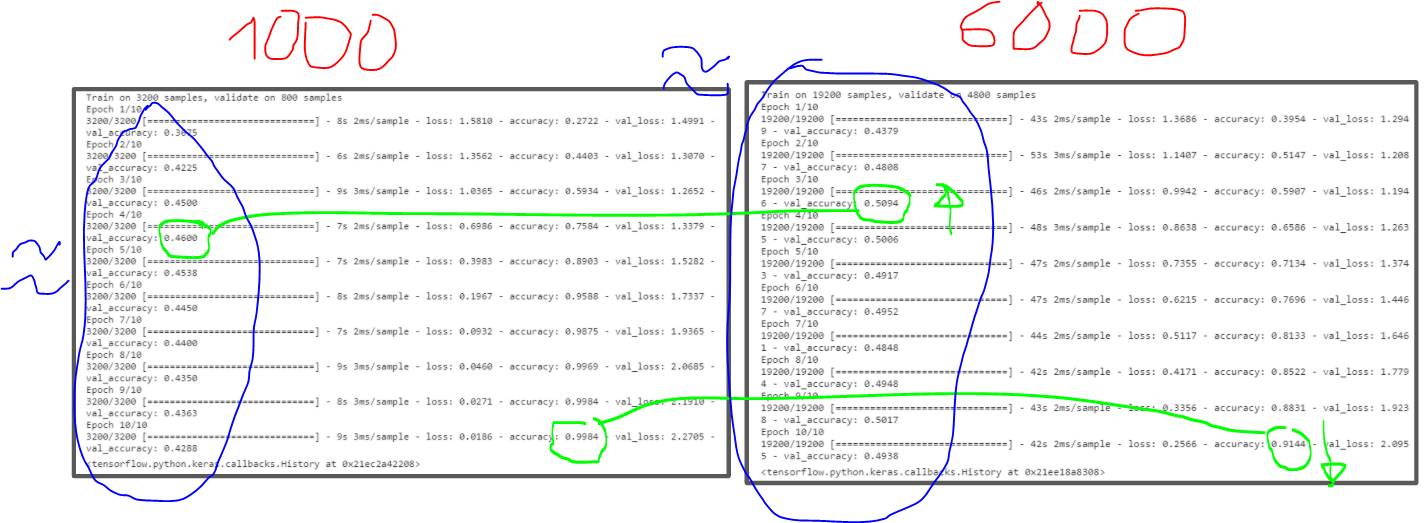

-------

<h2>Regularization through early stopping</h2>
<p>We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.</p>
<p>You can do this manually by inspecting the data as we have done above and modifying the <code>epochs</code> argument in <code>fit()</code>, but Keras also allows you to easily do this automatically via an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping"><code>EarlyStopping</code> callback</a>.</p>

<h3>Exercise 7:</h3>
<p>Experiment with the <code>EarlyStopping</code> callback and explain the results.</p>

**Answer.**

In [59]:
model_ex_7 = Sequential()
model_ex_7.add(Embedding(20000, 128, input_length=116))
model_ex_7.add(Dense(128, activation='relu'))
model_ex_7.add(Dense(128, activation='relu'))
model_ex_7.add(GlobalMaxPooling1D())
model_ex_7.add(Dense(5, activation='sigmoid'))
model_ex_7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Únicamente modificaremos esta linea respecto al modelo anterior
# (EarlyStopping debe llamarse al fit a tráves del argumento callbacks)
# monitor: corresponde con la cantidad que quiere ser monitoreada, empleada como criterio de parada
# mode: min (para cuando monitor haya dejado de disminuir),
#       max (para cuando minitor haya dejado de incrementar), 
#       auto (infiere el criterio de parada a partir de la cantidad monitoreada),
# restore_best_weights : True permite almacenar los w de al mejor iteración respecto al monitor
#                        False almacena los w de la última iteración

model_ex_7.fit(train_sequences, y_train, validation_split=0.2, epochs=10, 
               callbacks=[EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True)])

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 43s 2ms/sample - loss: 1.3624 - accuracy: 0.3998 - val_loss: 1.2881 - val_accuracy: 0.4294
Epoch 2/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 1.1267 - accuracy: 0.5231 - val_loss: 1.1908 - val_accuracy: 0.4892
Epoch 3/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 0.9752 - accuracy: 0.5996 - val_loss: 1.1904 - val_accuracy: 0.5063
Epoch 4/10
19200/19200 [==============================] - 42s 2ms/sample - loss: 0.8404 - accuracy: 0.6668 - val_loss: 1.2720 - val_accuracy: 0.4992


In this exercise we choose as monitor the accuracy value in the validation set, and as mode we choose to do it automatically. We can see that the model suspended its run once it found the one that val_accuracy started to decrease. Additionally, we use the restore_best_weightsen parameter in True mode, which allows the model not to take the values obtained from the last iteration, but from the best iteration with respect to the chosen monitor.

-------

<h2>Evaluating our model</h2>

<p>Unlike in most previous cases, we used <em>three</em> splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.</p>
<p>For experiments, it's very important that your model is only run <strong>once</strong> on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided <em>before the experiment started</em>).</p>

<h3>Exercise 8:</h3>
<p>Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose <em>what kinds of mistakes it makes</em>. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?</p>
<p><strong>Hint:</strong> You can use the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes"><code>predict_classes</code></a> method on your model to get the most probable class directly.</p>

**Answer.**

In [60]:
# Recordemos nuestro test_sequences que deberemos emplear 
# como dato de entrada para la predicción del modelo
# (son las palabras clasificadas del conjunto de test)
test_sequences

array([[  0,   0,   0, ...,   3, 201, 649],
       [  0,   0,   0, ...,  55, 273,  32],
       [  0,   0,   0, ..., 895, 561, 363],
       ...,
       [  0,   0,   0, ...,  20, 572,  12],
       [  0,   0,   0, ...,  82,  23,  99],
       [  0,   0,   0, ..., 194, 569,  73]])

In [61]:
# Recordemos tambien nuestro y_test que es el que deberemos 
# emplear para contrastar que tan bien ha hecho el modelo nuestra clasificación
# (son los target del conjunto de test)
y_test

25673    0
30225    3
37547    3
1624     4
29116    0
        ..
24693    0
24946    2
35365    3
2659     4
8269     4
Name: Score, Length: 6000, dtype: int64

In [62]:
# Generemos la predicción del modelo para nuestro conjunto de test
y_predict = model_ex_7.predict_classes(test_sequences)

# Imprimamos los valores predichos (denen ser valores entre 0 y 4)
print(y_predict)

# Corroboremos que la cantidad de registros corresponde con nuestro conjunto de test (6000)
print(len(y_predict))

[0 4 4 ... 4 4 4]
6000


In [63]:
# Calculemos el accuracy score entre los datos predichos y los datos "reales" del conjunto de test
accuracy_score(y_test, y_predict)

0.507

We find that the accuracy of the last model obtained from the prediction of the test set data is 50%. This value is significantly higher than the bechmark model already discussed. In order to evaluate how the correct and incorrect data are distributed, we will generate a confusion matrix that allows us to see which is the distribution of the predicted data:

<AxesSubplot:>

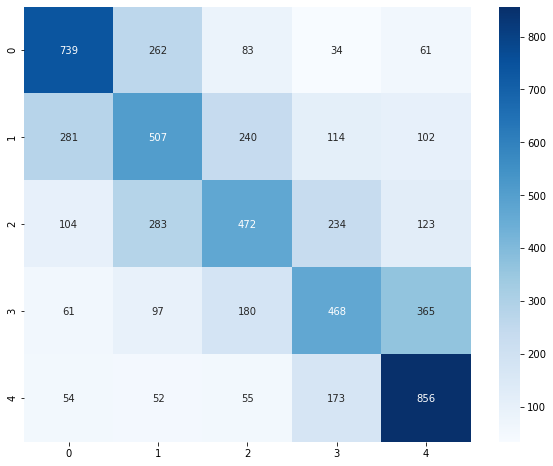

In [64]:
# Grafiquemos la matriz de confusión en un heatmap para identificar 
# de manera mas clara donde se focalizan los aciertos y donde los errores
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt="d",  cmap="Blues")

The results are completely consistent with expectations. We can describe the following results as the main ones:

**1. Values on the diagonal:** The values that are easier to predict and on which a greater accuracy prevails (since the sample taken was homogeneous for all types of qualification 0 to 4) are the highest or lowest qualifications. Comments that are highly exalting and completely repulsive should present very prominent keywords that allow a much simpler classification of these two "extreme" groups (highlighted in green).

We can see that as we move to the center on the diagonal, the intensity of the hits goes down, since classifying moderate comments, comments that can have good or bad characteristics simultaneously can be more ambiguous, so the hits are expected by assuming they are minor (highlighted in blue and red).

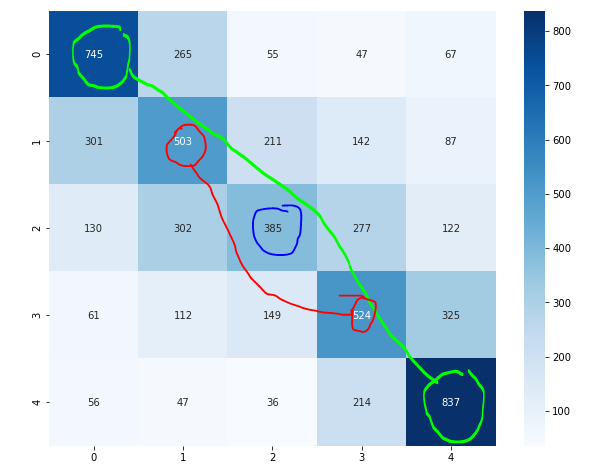

##### Examples

Next we will generate examples for each of the different types of selection for the values that can be found on the diagonal of the correlation matrix (predicted 'perfectly'), and already described in the previous paragraph:

In [65]:
# selection_01: Valor 'real' 4, valor predicho 4
selection_01 = list(set(y_test[y_test==4].index)&set(y_test[y_predict==4].index))
# selection_02: Valor 'real' 0, valor predicho 0
selection_02 = list(set(y_test[y_test==0].index)&set(y_test[y_predict==0].index))
# selection_03: Valor 'real' 1, valor predicho 1
selection_03 = list(set(y_test[y_test==1].index)&set(y_test[y_predict==1].index))
# selection_04: Valor 'real' 3, valor predicho 3
selection_04 = list(set(y_test[y_test==3].index)&set(y_test[y_predict==3].index))
# selection_05: Valor 'real' 2, valor predicho 2
selection_05 = list(set(y_test[y_test==2].index)&set(y_test[y_predict==2].index))

In [66]:
# Ejemplo selection_01: Valor 'real' 4, valor predicho 4
X_test[selection_01].reset_index(drop=True)[0]

"I love silken tofu and use it a lot to make smoothies for myself and my toddlers. This is good-quality silken tofu and I was happy with the price and convenience of having it delivered to my door. (It's hard to find in grocery stores around here!)"

In [67]:
# Ejemplo selection_02: Valor 'real' 0, valor predicho 0
X_test[selection_02].reset_index(drop=True)[0]

'So I jumped right in and read the reviews. Half good...half bad. These crackers are by far the worst tasting low carb crisps I have tried and the most expensive. maybe it was me? I gave one crisp to 3 other people and they all spit them out. They concur...gross. Grainy texture and dries your mouth out immediately after putting in mouth. Smells nasty. Guess what their return policy is?? No problem as long as you return the package in an "unused and resaleable" condition. Now how do you do that when you first try them? What a joke. Not even an offer of % off next purchase or exchange or anything other than your S.O.L.!! Buyer beware here for sure. Amazon should resist having sellers with this kind of return policy on products.'

In [68]:
# Ejemplo selection_03: Valor 'real' 1, valor predicho 1
X_test[selection_03].reset_index(drop=True)[0]

"I was very disappointed. It is good coffee, but doesn't have any flavor of chocolate. It smells like chocolate and that is it. Better used to fragrance your kitchen rather than drink."

In [69]:
# Ejemplo selection_04: Valor 'real' 3, valor predicho 3
X_test[selection_04].reset_index(drop=True)[0]

'I grew up on Quaker Oats and like these a little better.  Oats are oats, but there is something about these that seem a little hardier.  Good taste and texture as a morning hot cereal and good in baking (I have used these in a honey oat bread recipe).'

In [70]:
# Ejemplo selection_05: Valor 'real' 2, valor predicho 2
X_test[selection_05].reset_index(drop=True)[0]

"This is my second Illy coffee product and I guess I just don't like them. They are too strong and bitter-tasting for me. I'm not a lover of overly strong coffee flavors, I like them mild and unobtrusive. However, my husband has loved ever Illy product that I've given him to try, and he IS a coffee drinker. He likes anything coffee. So I'll give this a 3; my rating would have been a 1 but his would be a 5 so we'll split the difference.<br /><br />I do like how convenient the drinks are, they would fit nicely into my husband's lunchbox for work."

**2. Values outside the diagonal:** it is clear that the values that are outside the diagonal correspond to "misclassified" values, values for which the actual label and the label predicted by the model do not correspond EXACTLY. However, it is different to make a mistake classifying a comment as 4 when it was actually 0, to classifying it as 1 when it was actually zero.

Although acurracy may not account for it, there are a large number of predicted values on the two diagonals contiguous to the central diagonal (highlighted in green) that, although they do not present an exact classification, differ only 1 degree from their real classification given by the user. These data can also be considered "well classified" since the ambiguity between one degree and the next (especially if they are not extreme values) is difficult to generate. In this sense, to be wrong by 1 degree we could consider it not a mistake but a correct prediction that includes the uncertainty associated with the ambiguity of a qualification based on a text.

We can see that as we move away from the central diagonal, the remaining diagonals (from green to blue, from blue to red, from red to black) are presenting less and less misclassified values, which makes all the sense of the case. . The better the model works, the less it must go wrong as the difference in the grades of the qualification increases. In other words, there is a lower probability that a label with a real value of 4 is predicted as 0, than it is predicted with a label of 3. As we move away from the diagonal, these badly predicted values are reduced.

However, even at the extremes (values in black) you can find comments classified in their completely opposite value, this may be due to ironic comments that although they have words from the radically opposite group, their meaning may be a very different one from the words they contain.

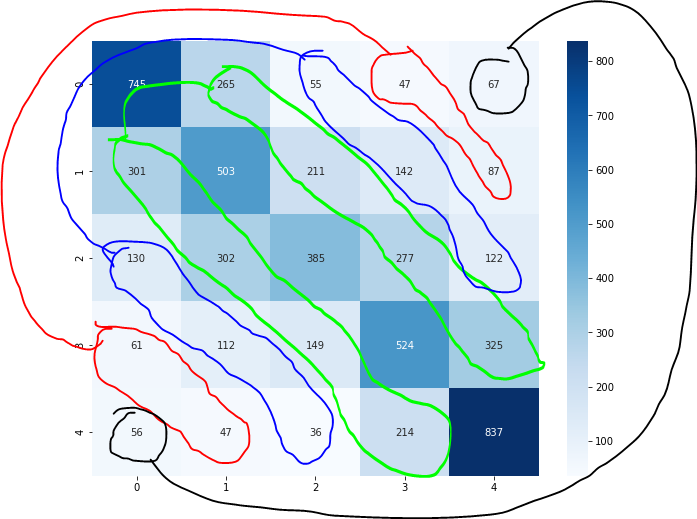

##### Examples

Next we will generate examples for each of the different types of selection for the values that can be found outside the diagonal of the correlation matrix (predicted 'incorrectly'), and already described in the previous paragraph:

In [71]:
# selection_06: Valor 'real' 4, valor predicho 0
selection_06 = list(set(y_test[y_test==4].index)&set(y_test[y_predict==0].index))
# selection_07: Valor 'real' 0, valor predicho 4
selection_07 = list(set(y_test[y_test==0].index)&set(y_test[y_predict==4].index))
# selection_08: Valor 'real' 1, valor predicho 0
selection_08 = list(set(y_test[y_test==1].index)&set(y_test[y_predict==0].index))
# selection_09: Valor 'real' 0, valor predicho 1
selection_09 = list(set(y_test[y_test==0].index)&set(y_test[y_predict==1].index))
# selection_10: Valor 'real' 2, valor predicho 3
selection_10 = list(set(y_test[y_test==2].index)&set(y_test[y_predict==3].index))

In [72]:
# Ejemplo selection_06: Valor 'real' 4, valor predicho 0
X_test[selection_06].reset_index(drop=True)[0]

"I tried the condensed version and thought it was horrible so was concerned that I would not like the powdered either.  Before I tried the powdered I had some of the fresh from my grocery store and really liked it.  As it turns out, this is quite the same as the fresh and about 60% cheaper.<br /><br />We are switching because both of my kids had ear infections galore and now sinus infections galore.  One was always constipated and still is to a certain extent.  And one is showing signs of hyperactivity, which some believe may be related to a food allergy (such as cow's milk).  So I figured better safe than sorry and am switching the whole family."

In [73]:
# Ejemplo selection_07: Valor 'real' 0, valor predicho 4
X_test[selection_07].reset_index(drop=True)[0]

'I wouldn\'t feed this to a pet.  Though the nutritional info shows \'0 Trans Fats\' the ingredients list shows "Partially Hydrogenated" oils... that is Trans Fats.  Basically, natural oils that have been modified by attaching two hydrogen molecules where they don\'t occur in nature.  The end result... the oil is solid a room temperature and creates a crispier product.  The impact to your health is that your system thinks it is oil (fat) and lets it into your blood stream where it is handled like a plastic.  You system doesn\'t know what to do with it and it is plastered on the walls of your arteries where it stays for a long long time.  Folks... if you care about Type 2 diabetes, cholesterol problems, altheimers disease... maybe more.  Keep these Trans Fats away from yourself and loved ones.  Also this material is hidden in names like "shortening" and "margarine".  Don\'t buy this... find a wafer that is safe.'

In [74]:
# Ejemplo selection_08: Valor 'real' 1, valor predicho 0
X_test[selection_08].reset_index(drop=True)[0]

'I used to order this cerial by the case and eat it every day.  When my most recent order arrived, they had changed the recipe.  The cerial is now terrible.  It is too sweet and tastes like molasses.  Definitely not recommended.'

In [75]:
# Ejemplo selection_09: Valor 'real' 0, valor predicho 1
X_test[selection_09].reset_index(drop=True)[0]

"After reading the reviews, I had my hopes up that I was going to bite into a soft chewy gummy bear whose texture was to die for.  Instead, I ate one and found them to be just a regular old gummy bear.  Flavor was good, texture was a bit too rubbery for my tastes, and honestly, I just don't see what the big deal is supposed to be about these gummy bears.  I ate about a pound and gave the remaining 4 lbs to my sister's kids who gobbled them up."

In [76]:
# Ejemplo selection_10: Valor 'real' 2, valor predicho 3
X_test[selection_10].reset_index(drop=True)[0]

"I suppose if you have been gluten free for a long time this bread is great, but it has a slightly sweet taste (some may like that) and its much like other gluten free breads, its very dense. It is better than most I've had though and the price is right.. I use it for bread crumbs to make meatballs.. something I haven't been able to do until recently.<br /><br />Its a good product for the money, considering how much a gluten free diet costs - I just couldn't use it for bread.. it does however make a decent pizza crust.. haven't tried it for much else."

##### Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?

Although I would not yet know how to implement a new metric different from the ones that the compile function's metrics parameter already has by default, the idea would be that a new accuracy could be created that would not qualify as correctly predicted or incorrectly predicted (exclusively 0 or 1), but had a weight relative to the diagonal distance for the 'wrong' predictions. According to what has already been discussed, we know that the values closest to the diagonal do not make sense that they are considered completely wrong but that it is part of the ambiguity of the qualification with a numerical value.

In theory this should make the neural network not only look at the values of the diagonal in its search for the weights for the best model, but also take into account the totality of the classifications.

-------

<p>Hopefully, you have seen from this that there is no one-size-fits-all method when creating model architectures or tuning parameters. Often times, copious experimentation is needed, and even then it can be difficult to get significantly better results than a baseline model or even really diagnose what is going wrong under the hood (since neural networks are so "black-box"). In many cases, the quantity and quality of the data itself is far more important than the architecture of the network for getting good results.</p>